# 11. Statistical Inference for Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch11_visual_summary.jpg" alt="Chapter 11 Visual Summary" width="65%">

This notebook provides an interactive introduction to extending inference to models with multiple regressors. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch11_Statistical_Inference_for_Multiple_Regression.ipynb)
<div class="chapter-resources">
<a href="https://www.youtube.com/watch?v=yvcSMmluY5Y" target="_blank" class="resource-btn">🎬 AI Video</a>
<a href="https://carlos-mendez.my.canva.site/s11-statistical-inference-for-multiple-regression-pdf" target="_blank" class="resource-btn">✨ AI Slides</a>
<a href="https://cameron.econ.ucdavis.edu/aed/traedv1_11" target="_blank" class="resource-btn">📊 Cameron Slides</a>
<a href="https://app.edcafe.ai/quizzes/697868ad2f5d08069e04b748" target="_blank" class="resource-btn">✏️ Quiz</a>
<a href="https://app.edcafe.ai/chatbots/6978a1572f5d08069e071814" target="_blank" class="resource-btn">🤖 AI Tutor</a>
</div>


## Chapter Overview

This chapter extends statistical inference to models with multiple regressors. You'll learn to construct confidence intervals, conduct hypothesis tests on individual and groups of parameters, and present regression results professionally.

**Learning Objectives:**

By the end of this chapter, you will be able to:

1. Extend statistical inference from bivariate regression to multiple regression with $k$ regressors
2. Understand the $t$-statistic for individual coefficients following a $T(n-k)$ distribution
3. Calculate and interpret standard errors for OLS slope coefficients: $se(b_j) = s_e / \sqrt{\sum \widetilde{x}_{ji}^2}$
4. Construct confidence intervals using $b_j \pm t_{n-k, \alpha/2} \times se(b_j)$
5. Conduct hypothesis tests on individual parameters to determine statistical significance
6. Understand and apply F-tests for joint hypotheses involving multiple parameter restrictions
7. Interpret the F distribution with two degrees of freedom ($v_1$ = restrictions, $v_2 = n-k$)
8. Perform the test of overall statistical significance using $H_0: \beta_2 = \cdots = \beta_k = 0$
9. Test whether subsets of regressors are jointly significant using nested model comparisons
10. Present regression results in standard formats (standard errors, t-statistics, p-values, confidence intervals, asterisks)

**Dataset used:**

- **AED_HOUSE.DTA**: 29 houses sold in Davis, California (1999)

**Key economic questions:**

- Is house size a statistically significant predictor of price?
- Are additional variables (bedrooms, bathrooms, age) jointly significant?
- What is a reasonable range for the effect of size on price?

**Chapter outline:**

- 11.1 Properties of the Least Squares Estimator
- 11.2 Estimators of Model Parameters
- 11.3 Confidence Intervals
- 11.4 Hypothesis Tests on a Single Parameter
- 11.5 Joint Hypothesis Tests
- 11.6 F Statistic Under Assumptions 1-4
- 11.7 Presentation of Regression Results
- Key Takeaways
- Practice Exercises
- Case Studies

**Estimated time:** 60-90 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.anova import anova_lm
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style (dark theme matching book design)
plt.style.use('dark_background')
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1a2235',
    'figure.facecolor': '#12162c',
    'grid.color': '#3a4a6b',
    'figure.figsize': (10, 6),
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': '#1a2235',
})

print("Setup complete! Ready to explore statistical inference for multiple regression.")

Setup complete! Ready to explore statistical inference for multiple regression.


### Data Preparation

We'll work with the same house price dataset from Chapter 10, which contains information on 29 houses sold in Davis, California in 1999.

In [2]:
# Read in the house data
data_house = pd.read_stata(GITHUB_DATA_URL + 'AED_HOUSE.DTA')

print("Data summary:")
data_summary = data_house.describe()
print(data_summary)

print("\nFirst few observations:")
print(data_house[['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']].head())

Data summary:
               price         size   bedrooms  bathrooms    lotsize        age  \
count      29.000000    29.000000  29.000000  29.000000  29.000000  29.000000   
mean   253910.344828  1882.758621   3.793103   2.206897   2.137931  36.413792   
std     37390.710695   398.272130   0.675030   0.341144   0.693034   7.118975   
min    204000.000000  1400.000000   3.000000   2.000000   1.000000  23.000000   
25%    233000.000000  1600.000000   3.000000   2.000000   2.000000  31.000000   
50%    244000.000000  1800.000000   4.000000   2.000000   2.000000  35.000000   
75%    270000.000000  2000.000000   4.000000   2.500000   3.000000  39.000000   
max    375000.000000  3300.000000   6.000000   3.000000   3.000000  51.000000   

       monthsold           list  
count  29.000000      29.000000  
mean    5.965517  257824.137931  
std     1.679344   40860.264099  
min     3.000000  199900.000000  
25%     5.000000  239000.000000  
50%     6.000000  245000.000000  
75%     7.000000  

## 11.1: Properties of the Least Squares Estimator

Before conducting inference, we need to understand the statistical properties of the OLS estimator. Under the classical linear regression assumptions, OLS has desirable properties.

**Classical Assumptions (1-4):**

1. **Linearity**: The population model is linear in parameters:
   $$y = \beta_1 + \beta_2 x_2 + \beta_3 x_3 + \cdots + \beta_k x_k + u$$

2. **Random sampling**: Data are randomly sampled from the population

3. **No perfect collinearity**: No exact linear relationships among regressors

4. **Zero conditional mean**: $E[u | x_2, \ldots, x_k] = 0$

**Properties of OLS under these assumptions:**

- **Unbiased**: $E[\hat{\beta}_j] = \beta_j$ (centered on true value)
- **Consistent**: $\hat{\beta}_j \rightarrow \beta_j$ as $n \rightarrow \infty$
- **Efficient (BLUE)**: Best Linear Unbiased Estimator (Gauss-Markov Theorem)
  - Has minimum variance among all linear unbiased estimators

**Standard error of coefficient $\hat{\beta}_j$:**

$$se(\hat{\beta}_j) = \frac{s_e}{\sqrt{\sum_{i=1}^n \tilde{x}_{ji}^2}}$$

where:

- $s_e$ is the standard error of the regression
- $\tilde{x}_{ji}$ is the residual from regressing $x_j$ on all other regressors

**Smaller standard errors occur when:**

- Model fits well (small $s_e$)
- Large sample size (large $\sum \tilde{x}_{ji}^2$)
- Variable $x_j$ has high variation after controlling for other regressors

In [3]:
print("=" * 70)
print("11.1 PROPERTIES OF THE LEAST SQUARES ESTIMATOR")
print("=" * 70)

print("\nUnder assumptions 1-4:")
print("  1. Linearity: y = β₀ + β₁x₁ + ... + βₖxₖ + u")
print("  2. Random sampling from population")
print("  3. No perfect collinearity")
print("  4. Zero conditional mean: E[u|X] = 0")
print("\nThe OLS estimator is:")
print("  - Unbiased: E[β̂] = β")
print("  - Consistent: plim(β̂) = β")
print("  - Efficient (BLUE under Gauss-Markov theorem)")
print("\nThese properties allow us to conduct valid statistical inference.")

11.1 PROPERTIES OF THE LEAST SQUARES ESTIMATOR

Under assumptions 1-4:
  1. Linearity: y = β₀ + β₁x₁ + ... + βₖxₖ + u
  2. Random sampling from population
  3. No perfect collinearity
  4. Zero conditional mean: E[u|X] = 0

The OLS estimator is:
  - Unbiased: E[β̂] = β
  - Consistent: plim(β̂) = β
  - Efficient (BLUE under Gauss-Markov theorem)

These properties allow us to conduct valid statistical inference.


> **Key Concept 11.1: Classical Assumptions for Statistical Inference**
>
> Four assumptions underpin valid inference in multiple regression: (1) linearity in parameters, (2) random sampling, (3) no perfect collinearity among regressors, and (4) zero conditional mean of errors $E[u|X] = 0$. Under these assumptions, OLS is unbiased ($E[b_j] = \beta_j$), consistent, and the Best Linear Unbiased Estimator (BLUE) by the Gauss-Markov theorem.

## 11.2: Estimators of Model Parameters

Now we estimate the full multiple regression model and examine the parameter estimates, standard errors, and related statistics.

**The full model:**

$$\text{price} = \beta_1 + \beta_2 \times \text{size} + \beta_3 \times \text{bedrooms} + \beta_4 \times \text{bathrooms} + \beta_5 \times \text{lotsize} + \beta_6 \times \text{age} + \beta_7 \times \text{monthsold} + u$$

**Key statistics:**

- **Coefficients** ($\hat{\beta}_j$): Point estimates of partial effects
- **Standard errors** ($se(\hat{\beta}_j)$): Measure of estimation uncertainty
- **t-statistics**: Coefficient divided by standard error
- **p-values**: Probability of observing such extreme values under $H_0: \beta_j = 0$
- **Root MSE** ($s_e$): Standard deviation of residuals, measures typical prediction error

In [4]:
# Full multiple regression model
model_full = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                 data=data_house).fit()

print("=" * 70)
print("11.2 ESTIMATORS OF MODEL PARAMETERS")
print("=" * 70)
print("\nFull Multiple Regression Results:")
print(model_full.summary())

11.2 ESTIMATORS OF MODEL PARAMETERS

Full Multiple Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.826
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           0.000342
Time:                        22:12:36   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

### Interpreting the Regression Results

**What these results tell us:**

The regression output reveals several important findings about the house price data:

1. **Size coefficient = \$68.37 (p < 0.001)**: Each additional square foot increases house price by \$68.37 on average, holding all other variables constant. This effect is highly statistically significant (p = 0.0002), meaning we can be very confident this relationship is not due to chance.

2. **Other variables are not statistically significant**:
   - **Bedrooms coefficient = \$2,685 (p = 0.773)**: Surprisingly, the number of bedrooms doesn't significantly affect price once we control for size. The p-value of 0.773 means we cannot reject the hypothesis that this coefficient is zero.
   - **Bathrooms coefficient = \$6,833 (p = 0.668)**: Similarly, bathrooms show no significant effect.
   - **Age coefficient = -\$833 (p = 0.259)**: Older homes tend to sell for less, but this effect is not statistically significant.

3. **Model fit: R² = 0.651**: The model explains 65.1% of the variation in house prices, which is quite good for cross-sectional real estate data.

4. **Overall F-statistic = 6.83 (p = 0.0003)**: The model as a whole is highly significant, meaning at least one of our predictors has a real effect on price.

**Economic Interpretation**: 

Size dominates all other house characteristics in determining price in this market. Features like number of bedrooms and bathrooms don't add explanatory power beyond what size already captures. This likely reflects multicollinearity—larger houses naturally tend to have more bedrooms and bathrooms, so once we control for size, these other features provide little additional information.

The large standard errors on most coefficients (relative to the coefficient values) suggest imprecise estimation, common in small samples (n=29) with correlated predictors.

### Model Diagnostics

Let's extract and display key model diagnostics to understand the estimation.

In [5]:
# Extract key statistics
n = len(data_house)
k = len(model_full.params)
df = n - k

print("Model diagnostics:")
print(f"  Sample size (n): {n}")
print(f"  Number of parameters (k): {k}")
print(f"  Degrees of freedom (n-k): {df}")
print(f"  Root MSE (σ̂): ${np.sqrt(model_full.mse_resid):,.2f}")
print(f"  R-squared: {model_full.rsquared:.4f}")
print(f"  Adjusted R-squared: {model_full.rsquared_adj:.4f}")

# Create comprehensive coefficient table
print("\n" + "=" * 70)
print("Coefficient Table")
print("=" * 70)
coef_table = pd.DataFrame({
    'Coefficient': model_full.params,
    'Std. Error': model_full.bse,
    't-statistic': model_full.tvalues,
    'p-value': model_full.pvalues
})
print(coef_table)

Model diagnostics:
  Sample size (n): 29
  Number of parameters (k): 7
  Degrees of freedom (n-k): 22
  Root MSE (σ̂): $24,935.73
  R-squared: 0.6506
  Adjusted R-squared: 0.5552

Coefficient Table
             Coefficient    Std. Error  t-statistic   p-value
Intercept  137791.065699  61464.951869     2.241783  0.035387
size           68.369419     15.389472     4.442610  0.000205
bedrooms     2685.315122   9192.525674     0.292119  0.772932
bathrooms    6832.880015  15721.191544     0.434629  0.668065
lotsize      2303.221371   7226.535205     0.318717  0.752947
age          -833.038602    719.334544    -1.158068  0.259254
monthsold   -2088.503625   3520.897859    -0.593174  0.559114


> **Key Concept 11.2: Precision of Coefficient Estimates**
>
> The standard error $se(b_j) = s_e / \sqrt{\sum \widetilde{x}_{ji}^2}$ reveals what makes estimates precise: (1) a well-fitting model (small $s_e$), (2) large sample size, (3) high variation in $x_j$ after controlling for other regressors, and (4) low multicollinearity. When regressors are highly correlated, $\sum \widetilde{x}_{ji}^2$ shrinks and standard errors inflate.

### Economic Interpretation

**Key findings:**

1. **Size coefficient** (≈ \$68.37): Each additional square foot increases house price by approximately \$68, holding other factors constant.

2. **Statistical significance**: Only the size variable appears statistically significant at conventional levels (p < 0.05).

3. **Other variables**: Bedrooms, bathrooms, lot size, age, and month sold show large standard errors relative to their coefficients, suggesting imprecise estimates.

This pattern is common in small samples with correlated regressors (multicollinearity).

Now that we understand the properties and interpretation of OLS estimates, let's quantify uncertainty through confidence intervals.

## 11.3: Confidence Intervals

A confidence interval provides a range of plausible values for a population parameter.

**Formula for a \$100(1-\alpha)\%$ confidence interval:**

$$\hat{\beta}_j \pm t_{n-k, \alpha/2} \times se(\hat{\beta}_j)$$

where:

- $\hat{\beta}_j$ is the coefficient estimate
- $t_{n-k, \alpha/2}$ is the critical value from Student's t-distribution
- $se(\hat{\beta}_j)$ is the standard error

**95% confidence interval (approximate):**

$$\hat{\beta}_j \pm 2 \times se(\hat{\beta}_j)$$

**Interpretation**: If we repeatedly sampled from the population and constructed 95% CIs, approximately 95% would contain the true parameter value.

**Key points:**

- Narrower intervals indicate more precise estimates
- If the interval excludes zero, the coefficient is statistically significant at that level

### Interpreting the Confidence Intervals

**What these confidence intervals tell us:**

Looking at the 95% confidence intervals, we can identify which variables have statistically significant effects:

1. **Size: [\$36.45, \$100.29]** - This interval excludes zero, confirming that size has a statistically significant positive effect on price. We are 95% confident that each additional square foot increases price by between \$36 and \$100.

2. **Intercept: [\$10,321, \$265,262]** - The wide interval reflects high uncertainty about the base price level, but it excludes zero.

3. **All other variables**: The confidence intervals for bedrooms, bathrooms, lotsize, age, and monthsold all **contain zero**, which means these coefficients are not statistically significant at the 5% level.

**Practical Meaning**:

If we repeatedly sampled 29 houses from this market and calculated 95% confidence intervals, approximately 95% of those intervals would contain the true population parameter. For the size coefficient, this means we're quite certain about its effect—even in the worst case (lower bound), an extra square foot adds at least \$36 to the price.

The fact that only the size interval excludes zero provides strong evidence that, in this dataset, size is the only reliable predictor of house prices among the variables we measured.

In [6]:
print("=" * 70)
print("11.3 CONFIDENCE INTERVALS")
print("=" * 70)

# 95% confidence intervals
conf_int = model_full.conf_int(alpha=0.05)
print("\n95% Confidence Intervals:")
print(conf_int)

11.3 CONFIDENCE INTERVALS

95% Confidence Intervals:
                      0              1
Intercept  10320.557398  265261.573999
size          36.453608     100.285230
bedrooms  -16378.816300   21749.446543
bathrooms -25770.875723   39436.635753
lotsize   -12683.695364   17290.138107
age        -2324.847139     658.769936
monthsold  -9390.398871    5213.391620


### Manual Calculation of Confidence Interval

Let's manually calculate the confidence interval for the size coefficient to understand the mechanics.

In [7]:
# Detailed confidence interval calculation for 'size'
coef_size = model_full.params['size']
se_size = model_full.bse['size']
t_crit = stats.t.ppf(0.975, df)  # 97.5th percentile for two-sided 95% CI

ci_lower = coef_size - t_crit * se_size
ci_upper = coef_size + t_crit * se_size

print("Manual calculation for 'size' coefficient:")
print(f"  Coefficient: ${coef_size:.2f}")
print(f"  Standard error: ${se_size:.2f}")
print(f"  Degrees of freedom: {df}")
print(f"  Critical t-value (α=0.05): {t_crit:.4f}")
print(f"  Margin of error: {t_crit * se_size:.2f}")
print(f"  95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}]")

print("\nInterpretation:")
print(f"We are 95% confident that each additional square foot increases")
print(f"house price by between ${ci_lower:.2f} and ${ci_upper:.2f}.")

Manual calculation for 'size' coefficient:
  Coefficient: $68.37
  Standard error: $15.39
  Degrees of freedom: 22
  Critical t-value (α=0.05): 2.0739
  Margin of error: 31.92
  95% CI: [$36.45, $100.29]

Interpretation:
We are 95% confident that each additional square foot increases
house price by between $36.45 and $100.29.


### Comprehensive Table with Confidence Intervals

In [8]:
# Create comprehensive coefficient table
print("=" * 70)
print("Comprehensive Coefficient Table with 95% Confidence Intervals")
print("=" * 70)
coef_table_full = pd.DataFrame({
    'Coefficient': model_full.params,
    'Std. Error': model_full.bse,
    't-statistic': model_full.tvalues,
    'p-value': model_full.pvalues,
    'CI Lower': conf_int.iloc[:, 0],
    'CI Upper': conf_int.iloc[:, 1]
})
print(coef_table_full)

print("\nNote: Coefficients with CIs that exclude zero are statistically significant at 5%.")

Comprehensive Coefficient Table with 95% Confidence Intervals
             Coefficient    Std. Error  t-statistic   p-value      CI Lower  \
Intercept  137791.065699  61464.951869     2.241783  0.035387  10320.557398   
size           68.369419     15.389472     4.442610  0.000205     36.453608   
bedrooms     2685.315122   9192.525674     0.292119  0.772932 -16378.816300   
bathrooms    6832.880015  15721.191544     0.434629  0.668065 -25770.875723   
lotsize      2303.221371   7226.535205     0.318717  0.752947 -12683.695364   
age          -833.038602    719.334544    -1.158068  0.259254  -2324.847139   
monthsold   -2088.503625   3520.897859    -0.593174  0.559114  -9390.398871   

                CI Upper  
Intercept  265261.573999  
size          100.285230  
bedrooms    21749.446543  
bathrooms   39436.635753  
lotsize     17290.138107  
age           658.769936  
monthsold    5213.391620  

Note: Coefficients with CIs that exclude zero are statistically significant at 5%.


> **Key Concept 11.3: Confidence Intervals in Multiple Regression**
>
> A 95% confidence interval $b_j \pm t_{n-k, 0.025} \times se(b_j)$ provides a range of plausible values for $\beta_j$. If the interval excludes zero, the coefficient is statistically significant at 5%. Narrower intervals indicate more precise estimation, which improves with larger samples and lower multicollinearity.

### Interpreting the Hypothesis Test Result

**What this test tells us:**

We tested whether the size coefficient equals 50 (H₀: β_size = 50):

- **t-statistic = 1.19**: This measures how many standard errors our estimate (\$68.37) is away from the hypothesized value (50). The difference is 1.19 standard errors.

- **p-value = 0.245**: This is the probability of observing a coefficient as extreme as \$68.37 (or more extreme) if the true value were actually \$50. A p-value of 0.245 means there's about a 25% chance we'd see this result by random sampling variation alone.

- **Decision**: Since p = 0.245 > 0.05, we **fail to reject** H₀ at the 5% significance level.

**Economic Interpretation**:

The data are consistent with the hypothesis that each square foot adds \$50 to house price. Even though our point estimate is \$68.37, the difference from \$50 is not statistically significant. This doesn't mean β = 50 is correct—it simply means our data don't provide strong enough evidence to rule it out.

This illustrates an important principle: **failing to reject H₀ is NOT the same as proving H₀ is true**. We simply lack sufficient evidence to reject it given our sample size and estimation precision.

## 11.4: Hypothesis Tests on a Single Parameter

Hypothesis testing allows us to make formal inferences about population parameters.

**General two-sided test:**

$$H_0: \beta_j = \beta_j^* \quad \text{vs.} \quad H_a: \beta_j \neq \beta_j^*$$

**Test statistic:**

$$t = \frac{\hat{\beta}_j - \beta_j^*}{se(\hat{\beta}_j)} \sim t(n-k)$$

**Decision rules:**

1. **p-value approach**: Reject $H_0$ if $p$-value $< \alpha$
2. **Critical value approach**: Reject $H_0$ if $|t| > t_{n-k, \alpha/2}$

**Test of statistical significance** (most common):

$$H_0: \beta_j = 0 \quad \text{vs.} \quad H_a: \beta_j \neq 0$$

This tests whether variable $x_j$ has any relationship with $y$ after controlling for other regressors.

**Example**: Test whether the size coefficient equals 50.

In [9]:
print("=" * 70)
print("11.4 HYPOTHESIS TESTS ON A SINGLE PARAMETER")
print("=" * 70)

# Test H₀: β_size = 50 vs H₁: β_size ≠ 50
null_value = 50
t_stat_50 = (coef_size - null_value) / se_size
p_value_50 = 2 * (1 - stats.t.cdf(abs(t_stat_50), df))

print(f"\nTest: H₀: β_size = {null_value} vs H₁: β_size ≠ {null_value}")
print(f"  Coefficient estimate: ${coef_size:.2f}")
print(f"  Standard error: ${se_size:.2f}")
print(f"  t-statistic: {t_stat_50:.4f}")
print(f"  p-value: {p_value_50:.4f}")
print(f"  Critical value (α=0.05): ±{t_crit:.4f}")

if abs(t_stat_50) > t_crit:
    print(f"\nResult: Reject H₀ at 5% significance level")
    print(f"  Conclusion: The size coefficient is significantly different from {null_value}.")
else:
    print(f"\nResult: Fail to reject H₀ at 5% significance level")
    print(f"  Conclusion: The data are consistent with β_size = {null_value}.")

11.4 HYPOTHESIS TESTS ON A SINGLE PARAMETER

Test: H₀: β_size = 50 vs H₁: β_size ≠ 50
  Coefficient estimate: $68.37
  Standard error: $15.39
  t-statistic: 1.1936
  p-value: 0.2453
  Critical value (α=0.05): ±2.0739

Result: Fail to reject H₀ at 5% significance level
  Conclusion: The data are consistent with β_size = 50.


### Test of Statistical Significance (β = 0)

The most common hypothesis test examines whether a coefficient is zero.

In [10]:
# Test H₀: β_size = 0 (statistical significance)
print("=" * 70)
print("Test of Statistical Significance: H₀: β_size = 0")
print("=" * 70)

t_stat_zero = coef_size / se_size
p_value_zero = model_full.pvalues['size']

print(f"\n  t-statistic: {t_stat_zero:.4f}")
print(f"  p-value: {p_value_zero:.6f}")
print(f"  Critical value (α=0.05): ±{t_crit:.4f}")

if p_value_zero < 0.05:
    print(f"\nResult: Reject H₀ - Size is statistically significant at 5% level")
    print(f"  Interpretation: House size has a statistically significant effect on price.")
else:
    print(f"\nResult: Fail to reject H₀ - Size is not statistically significant")

Test of Statistical Significance: H₀: β_size = 0

  t-statistic: 4.4426
  p-value: 0.000205
  Critical value (α=0.05): ±2.0739

Result: Reject H₀ - Size is statistically significant at 5% level
  Interpretation: House size has a statistically significant effect on price.


> **Key Concept 11.4: Tests of Statistical Significance**
>
> The most common hypothesis test examines $H_0: \beta_j = 0$ — whether variable $x_j$ has any partial effect on $y$. The $t$-statistic $t = b_j/se(b_j)$ measures how many standard errors the estimate is from zero. Reject $H_0$ when $|t| > t_{\text{critical}}$ or equivalently when the $p$-value $< \alpha$.

### Using statsmodels t_test

Python's statsmodels package provides convenient methods for hypothesis testing.

In [11]:
# Using statsmodels t_test
print("=" * 70)
print("Hypothesis test using statsmodels t_test:")
print("=" * 70)
hypothesis = f'size = {null_value}'
t_test_result = model_full.t_test(hypothesis)
print(t_test_result)

print("\nThis confirms our manual calculation.")

Hypothesis test using statsmodels t_test:
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            68.3694     15.389      1.194      0.245      36.454     100.285

This confirms our manual calculation.


Having tested individual coefficients, we now turn to joint hypothesis tests that evaluate multiple restrictions simultaneously.

## 11.5: Joint Hypothesis Tests

Sometimes we want to test multiple restrictions simultaneously. Individual t-tests are insufficient for this purpose.

**Why joint tests?**

- Testing multiple individual hypotheses separately can be misleading
- Joint tests account for correlation between coefficient estimates

**Examples of joint hypotheses:**

1. All slope coefficients equal zero: $\beta_2 = \beta_3 = \cdots = \beta_k = 0$
2. Subset of coefficients equal zero: $\beta_3 = \beta_4 = \beta_5 = 0$
3. Linear restrictions: $\beta_2 = -\beta_3$ and \$2\beta_4 + \beta_6 = 9$

**F-test procedure:**

- Test statistic follows the F-distribution: $F(q, n-k)$
- $q$ = number of restrictions
- $n-k$ = degrees of freedom

**F-distribution properties:**

- Always positive (right-skewed)
- Depends on two degrees of freedom parameters
- As $q$ or $n-k$ increases, critical values change

### Interpreting the Overall F-test

**What this F-test tells us:**

The overall F-test examines whether our model has any explanatory power at all:

- **Null hypothesis**: All slope coefficients equal zero (β₂ = β₃ = ... = β₇ = 0)
- **Alternative**: At least one coefficient is non-zero

**Results:**

- **F-statistic = 6.83**: This compares the explained variation to unexplained variation
- **p-value = 0.0003**: Extremely small probability of observing such a large F-statistic if all coefficients were truly zero
- **Critical value = 2.55**: Our F-statistic (6.83) far exceeds this threshold

**Decision**: **Reject H₀** - The model is highly statistically significant.

**Economic Interpretation**:

This result tells us that **at least one** of our house characteristics (size, bedrooms, bathrooms, lotsize, age, monthsold) has a real relationship with price. Given that we already know size is significant from individual t-tests, this makes sense.

However, this test doesn't tell us **which** variables matter—just that the model as a whole provides useful information for predicting house prices. The very small p-value (0.0003) gives us high confidence that our model captures real economic relationships, not just random noise.

### Interpreting the Joint Test of Subset Variables

**What this joint test tells us:**

This F-test asks: "Can we exclude bedrooms, bathrooms, lotsize, age, and monthsold from the model and just keep size?"

**Results:**

- **F-statistic = 0.42**: Very small F-statistic
- **p-value = 0.832**: Very high p-value (83.2%)
- **Critical value = 2.66**: Our F-statistic (0.42) is far below this threshold

**Decision**: **Fail to reject H₀** - These five variables are NOT jointly significant.

**Economic Interpretation**:

This is a crucial finding for model selection. Even though we're testing five variables simultaneously, they collectively add almost nothing to the model's explanatory power beyond what size alone provides.

**What this means in practice:**

- A **simpler model** with only size as a predictor would be preferred
- The additional variables (bedrooms, bathrooms, etc.) don't improve our ability to predict house prices
- Keeping these variables makes the model more complex without meaningful benefit

This result demonstrates the power of joint testing: while we might hope that bedrooms or bathrooms would add information, when tested together, they fail to improve the model. This likely reflects the strong correlation between size and these other features—bigger houses tend to have more bedrooms and bathrooms, so these variables don't provide independent information.

### Interpreting the Sum of Squares Decomposition

**What these calculations show:**

The sum of squares decomposition breaks down the total variation in house prices:

- **TSS = \$39,145,826,897** (Total Sum of Squares): Total variation in house prices around their mean
- **ESS = \$25,466,429,042** (Explained Sum of Squares): Variation explained by our model (65.1%)
- **RSS = \$13,679,397,855** (Residual Sum of Squares): Variation left unexplained (34.9%)

**Verification**: TSS = ESS + RSS (The identity holds perfectly)

**Understanding the F-statistic:**

The F-statistic compares explained variation per parameter to unexplained variation per degree of freedom:

$$F = \frac{ESS/(k-1)}{RSS/(n-k)} = \frac{25,466,429,042/6}{13,679,397,855/22} = 6.83$$

**Economic Interpretation**:

Our model explains about 65% of the variation in house prices—a respectable amount for real estate data. The remaining 35% reflects unmeasured factors like neighborhood quality, interior condition, proximity to amenities, etc.

The F-statistic of 6.83 tells us that the explained variation (per parameter) is nearly 7 times larger than the unexplained variation (per degree of freedom). This ratio is large enough to conclude the model has genuine explanatory power, not just capturing random noise.

In [12]:
print("=" * 70)
print("11.5 JOINT HYPOTHESIS TESTS")
print("=" * 70)

# Test 1: Joint significance of all slope coefficients
# H₀: β₁ = β₂ = ... = βₖ = 0
print("\n" + "-" * 70)
print("Test 1: Overall F-test (all slopes = 0)")
print("-" * 70)

f_stat = model_full.fvalue
f_pvalue = model_full.f_pvalue
dfn = k - 1  # numerator df (excluding intercept)
dfd = df     # denominator df
f_crit = stats.f.ppf(0.95, dfn, dfd)

print(f"  H₀: All slope coefficients equal zero")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {f_pvalue:.6e}")
print(f"  Critical value (α=0.05): {f_crit:.4f}")
print(f"  Numerator df: {dfn}, Denominator df: {dfd}")

if f_stat > f_crit:
    print("\nResult: Reject H₀ - At least one coefficient is non-zero")
    print("  Interpretation: The regressors are jointly statistically significant.")
else:
    print("\nResult: Fail to reject H₀")

11.5 JOINT HYPOTHESIS TESTS

----------------------------------------------------------------------
Test 1: Overall F-test (all slopes = 0)
----------------------------------------------------------------------
  H₀: All slope coefficients equal zero
  F-statistic: 6.8261
  p-value: 3.424253e-04
  Critical value (α=0.05): 2.5491
  Numerator df: 6, Denominator df: 22

Result: Reject H₀ - At least one coefficient is non-zero
  Interpretation: The regressors are jointly statistically significant.


### Joint Test of Subset of Coefficients

Now test whether variables other than size are jointly significant.

In [13]:
# Test 2: Joint test of subset of coefficients
# H₀: β_bedrooms = β_bathrooms = β_lotsize = β_age = β_monthsold = 0
print("\n" + "-" * 70)
print("Test 2: Joint test - Are variables other than size significant?")
print("-" * 70)

hypotheses = ['bedrooms = 0', 'bathrooms = 0', 'lotsize = 0',
              'age = 0', 'monthsold = 0']
f_test_result = model_full.f_test(hypotheses)
print(f_test_result)

print(f"\nInterpretation:")
print(f"  This tests whether bedrooms, bathrooms, lotsize, age, and monthsold")
print(f"  can jointly be excluded from the model (keeping only size).")

if f_test_result.pvalue < 0.05:
    print(f"  Result: These variables are jointly significant.")
else:
    print(f"  Result: These variables are NOT jointly significant.")
    print(f"  A simpler model with only size may be preferred.")


----------------------------------------------------------------------
Test 2: Joint test - Are variables other than size significant?
----------------------------------------------------------------------
<F test: F=0.41676518071663304, p=0.8319758671771483, df_denom=22, df_num=5>

Interpretation:
  This tests whether bedrooms, bathrooms, lotsize, age, and monthsold
  can jointly be excluded from the model (keeping only size).
  Result: These variables are NOT jointly significant.
  A simpler model with only size may be preferred.


> **Key Concept 11.5: Joint Hypothesis Tests and the F Distribution**
>
> Individual $t$-tests cannot test multiple restrictions simultaneously because they ignore correlations between coefficient estimates. The F-test evaluates joint significance using the $F(q, n-k)$ distribution, where $q$ is the number of restrictions. It compares how much worse the restricted model fits relative to the unrestricted model.

### Interpreting the Subset F-test

**What this subset F-test tells us:**

We're comparing two models:

- **Restricted model**: price ~ size (2 parameters)
- **Unrestricted model**: price ~ size + bedrooms + bathrooms + lotsize + age + monthsold (7 parameters)

**Key numbers:**

- **RSS (restricted) = \$14,975,101,655**: Prediction errors when using only size
- **RSS (unrestricted) = \$13,679,397,855**: Prediction errors when using all variables
- **Increase in RSS = \$1,295,703,800**: How much worse the restricted model fits

**Test results:**

- **F-statistic = 0.42**: The increase in RSS is small relative to the baseline error
- **p-value = 0.832**: 83.2% probability of seeing this result if the restrictions are true
- **Critical value = 2.66**: Our F-statistic is far below the threshold

**Decision**: **Fail to reject H₀** - The restricted model (only size) is NOT significantly worse.

**Economic Interpretation**:

This is a powerful result for **model selection**. Adding five additional variables (bedrooms, bathrooms, lotsize, age, monthsold) reduces prediction errors by only \$1.3 million out of \$15 million total—a mere 8.7% improvement. This improvement is so small it could easily be due to random chance.

**Practical recommendation**: Use the **simpler model** with only size. It's easier to interpret, requires less data collection, and performs nearly as well as the complex model. This is an application of **Occam's Razor** in econometrics: prefer simpler models when complex ones don't provide meaningful improvement.

## 11.6: F Statistic Under Assumptions 1-4

Under the classical assumptions, the F-statistic has a specific formula based on sums of squares.

**Sum of Squares Decomposition:**

$$TSS = ESS + RSS$$

where:

- **TSS** (Total Sum of Squares) = $\sum (y_i - \bar{y})^2$
- **ESS** (Explained Sum of Squares) = $\sum (\hat{y}_i - \bar{y})^2$
- **RSS** (Residual Sum of Squares) = $\sum (y_i - \hat{y}_i)^2$

**F-statistic formula:**

$$F = \frac{(RSS_r - RSS_u) / q}{RSS_u / (n-k)} \sim F(q, n-k)$$

where:

- $RSS_r$ = RSS from restricted model
- $RSS_u$ = RSS from unrestricted model
- $q$ = number of restrictions

**Intuition**: Reject restrictions if the restricted model fits much worse (large increase in RSS).

**Overall F-test formula:**

$$F = \frac{R^2 / (k-1)}{(1-R^2) / (n-k)} \sim F(k-1, n-k)$$

In [14]:
print("=" * 70)
print("11.6 F STATISTIC UNDER ASSUMPTIONS 1-4")
print("=" * 70)

# Manual calculation of F-statistic using sums of squares
print("\n" + "-" * 70)
print("Manual F-statistic calculation")
print("-" * 70)

# Calculate sum of squares
y = data_house['price']
y_mean = y.mean()
y_pred = model_full.fittedvalues
resid = model_full.resid

# Total sum of squares
TSS = np.sum((y - y_mean)**2)
# Explained sum of squares
ESS = np.sum((y_pred - y_mean)**2)
# Residual sum of squares
RSS = np.sum(resid**2)

print(f"Sum of Squares:")
print(f"  Total (TSS): {TSS:,.2f}")
print(f"  Explained (ESS): {ESS:,.2f}")
print(f"  Residual (RSS): {RSS:,.2f}")
print(f"  Check: TSS = ESS + RSS: {np.isclose(TSS, ESS + RSS)}")

# F-statistic
f_stat_manual = (ESS / (k-1)) / (RSS / df)
print(f"\nF-statistic calculation:")
print(f"  F = (ESS/{k-1}) / (RSS/{df})")
print(f"  F = ({ESS:,.2f}/{k-1}) / ({RSS:,.2f}/{df})")
print(f"  F = {f_stat_manual:.4f}")
print(f"  From model output: {f_stat:.4f}")
print(f"  Match: {np.isclose(f_stat_manual, f_stat)}")

# Alternative formula using R²
r_squared = model_full.rsquared
f_stat_rsq = (r_squared / (k-1)) / ((1 - r_squared) / df)
print(f"\nAlternative formula using R²:")
print(f"  F = (R²/(k-1)) / ((1-R²)/(n-k))")
print(f"  F = ({r_squared:.4f}/{k-1}) / ({1-r_squared:.4f}/{df})")
print(f"  F = {f_stat_rsq:.4f}")
print(f"  Match: {np.isclose(f_stat_rsq, f_stat)}")

11.6 F STATISTIC UNDER ASSUMPTIONS 1-4

----------------------------------------------------------------------
Manual F-statistic calculation
----------------------------------------------------------------------
Sum of Squares:
  Total (TSS): 39,145,826,896.55
  Explained (ESS): 25,466,429,041.83
  Residual (RSS): 13,679,397,854.73
  Check: TSS = ESS + RSS: True

F-statistic calculation:
  F = (ESS/6) / (RSS/22)
  F = (25,466,429,041.83/6) / (13,679,397,854.73/22)
  F = 6.8261
  From model output: 6.8261
  Match: True

Alternative formula using R²:
  F = (R²/(k-1)) / ((1-R²)/(n-k))
  F = (0.6506/6) / (0.3494/22)
  F = 6.8261
  Match: True


> **Key Concept 11.6: The F Statistic Under Homoskedasticity**
>
> Under assumptions 1-4, the F-statistic can be computed from sums of squares: $F = [(RSS_r - RSS_u)/q] / [RSS_u/(n-k)]$, or equivalently from $R^2$: $F = [(R_u^2 - R_r^2)/q] / [(1-R_u^2)/(n-k)]$. Larger F-values indicate the restrictions are inconsistent with the data.

### Subset F-test: Restricted vs Unrestricted Model

Now we compare the full model (unrestricted) with a simpler model containing only size (restricted).

### Interpreting the Model Comparison

**What this comparison reveals:**

Comparing three nested models helps us understand the incremental value of adding variables:

**Model 1 (Simple): price ~ size**

- **R² = 0.618**, **Adj. R² = 0.603**: Explains 61.8% of price variation
- **F-stat = 43.58**: Very strong overall significance
- **Simplest and most parsimonious**

**Model 2 (Intermediate): price ~ size + bedrooms**

- **R² = 0.618**, **Adj. R² = 0.589**: Almost identical R² to Model 1
- **F-stat = 21.03**: Still significant, but weaker than Model 1
- **Adding bedrooms barely improves fit**

**Model 3 (Full): price ~ size + bedrooms + bathrooms + lotsize + age + monthsold**

- **R² = 0.651**, **Adj. R² = 0.555**: Highest R², but **lowest adjusted R²**
- **F-stat = 6.83**: Weakest overall significance (though still significant)
- **Complexity penalty outweighs small improvement in fit**

**Key insights:**

1. **Adjusted R² is crucial**: While R² increases with more variables (always), adjusted R² accounts for the complexity penalty. Model 1 has the **highest adjusted R²**, indicating the best balance of fit and simplicity.

2. **Diminishing returns**: Adding bedrooms (Model 2) provides essentially no improvement. Adding five more variables (Model 3) only increases R² from 0.618 to 0.651—a marginal gain.

3. **Statistical vs. practical significance**: Model 3 is statistically significant overall (F = 6.83, p < 0.001), but that doesn't mean it's the **best** model. Model 1 is superior on parsimony grounds.

**Recommendation**: **Use Model 1** (size only). It's simpler, has the highest adjusted R², and loses almost nothing in explanatory power compared to more complex alternatives.

In [15]:
# Subset F-test using restricted and unrestricted models
print("\n" + "-" * 70)
print("Subset F-test: Restricted vs Unrestricted Model")
print("-" * 70)

# Unrestricted model (already estimated as model_full)
# Restricted model (only size as regressor)
model_restricted = ols('price ~ size', data=data_house).fit()

print("\nRestricted model (only size):")
print(model_restricted.summary())


----------------------------------------------------------------------
Subset F-test: Restricted vs Unrestricted Model
----------------------------------------------------------------------

Restricted model (only size):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     43.58
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           4.41e-07
Time:                        22:12:36   Log-Likelihood:                -332.05
No. Observations:                  29   AIC:                             668.1
Df Residuals:                      27   BIC:                             670.8
Df Model:                           1                                         
Covariance Type:            nonrobust                              

### Interpreting Coefficient Stability Across Models

**What this table reveals about coefficient estimates:**

Tracking how coefficients change as we add variables helps diagnose **multicollinearity** and understand variable relationships:

**Size coefficient across models:**

- **Model 1**: \$73.77 (SE = \$11.17)
- **Model 2**: \$73.65 (SE = \$11.50)  
- **Model 3**: \$68.37 (SE = \$15.39)

**What we observe:**

1. **Relatively stable point estimates**: The size coefficient ranges from \$68-\$74 across models, suggesting the relationship is genuine and robust.

2. **Increasing standard errors**: As we add variables, the SE increases from \$11 to \$15—a 38% increase. This reflects **multicollinearity**: size is correlated with other variables (larger houses have more bedrooms, bathrooms, etc.).

3. **Precision loss**: In Model 1, we can estimate the size effect quite precisely (SE = \$11). Adding correlated variables inflates uncertainty without improving the overall fit much.

**Bedrooms paradox:**

- When added in Model 2, bedrooms show essentially no effect
- In Model 3, the coefficient is \$2,685 but with a huge SE of \$9,193
- This means bedrooms add no information beyond what size already provides

**Economic lesson:**

This pattern is common in real estate data: once you control for total square footage, the number of rooms matters little. Two houses of identical size but different room configurations (e.g., one with 3 large bedrooms vs. one with 4 small bedrooms) sell for similar prices. **Size is what buyers care about, not how that space is divided.**

### Manual F-test Calculation

### Interpreting Robust Standard Errors

**What robust standard errors tell us:**

Heteroskedasticity-robust (HC1) standard errors correct for potential violations of the constant variance assumption. Comparing standard vs. robust errors helps diagnose whether heteroskedasticity is a concern:

**Size coefficient:**

- **Standard SE**: \$15.39 → **Robust SE**: \$15.15
- **Change**: Slight decrease (1.6%)
- **Both t-stats highly significant** (p ≈ 0.0002)

**Intercept:**

- **Standard SE**: \$61,465 → **Robust SE**: \$69,273
- **Change**: Increase of 12.7%
- **p-value changes**: 0.035 → 0.047 (still significant, but closer to the boundary)

**Other variables:**

- Most show minor changes in SEs
- All remain statistically insignificant with robust SEs
- Conclusions unchanged

**What this means:**

1. **Mild heteroskedasticity**: The fact that robust SEs are similar to standard SEs suggests heteroskedasticity is not a major problem in this dataset. If it were severe, we'd see much larger increases in robust SEs.

2. **Conclusions are robust**: The key finding—that size is significant while other variables are not—holds regardless of which SE we use.

3. **Best practice**: For cross-sectional data like housing prices, it's wise to **report robust SEs by default**. They provide valid inference whether or not heteroskedasticity is present, with minimal cost.

4. **Intercept sensitivity**: The intercept shows the largest change, but intercepts are rarely of economic interest. Our substantive conclusions about slope coefficients remain unchanged.

In [16]:
# Calculate F-statistic for subset test
k_unrest = len(model_full.params)
k_rest = len(model_restricted.params)
q = k_unrest - k_rest  # number of restrictions

RSS_unrest = np.sum(model_full.resid**2)
RSS_rest = np.sum(model_restricted.resid**2)
df_unrest = n - k_unrest

F_subset = ((RSS_rest - RSS_unrest) / q) / (RSS_unrest / df_unrest)
p_value_subset = 1 - stats.f.cdf(F_subset, q, df_unrest)
f_crit_subset = stats.f.ppf(0.95, q, df_unrest)

print("\nSubset F-test results:")
print(f"  Number of restrictions (q): {q}")
print(f"  RSS (restricted): {RSS_rest:,.2f}")
print(f"  RSS (unrestricted): {RSS_unrest:,.2f}")
print(f"  Increase in RSS: {RSS_rest - RSS_unrest:,.2f}")
print(f"  F-statistic: {F_subset:.4f}")
print(f"  p-value: {p_value_subset:.4f}")
print(f"  Critical value (α=0.05): {f_crit_subset:.4f}")

if F_subset > f_crit_subset:
    print("\nResult: Reject H₀ - The additional variables are jointly significant")
    print("  Keep the full model.")
else:
    print("\nResult: Fail to reject H₀ - The additional variables are NOT jointly significant")
    print("  The simpler model (only size) is preferred.")


Subset F-test results:
  Number of restrictions (q): 5
  RSS (restricted): 14,975,101,654.50
  RSS (unrestricted): 13,679,397,854.73
  Increase in RSS: 1,295,703,799.78
  F-statistic: 0.4168
  p-value: 0.8320
  Critical value (α=0.05): 2.6613

Result: Fail to reject H₀ - The additional variables are NOT jointly significant
  The simpler model (only size) is preferred.


### ANOVA Table Comparison

In [17]:
# Using ANOVA table for comparison
print("\n" + "-" * 70)
print("ANOVA table comparison")
print("-" * 70)
anova_results = anova_lm(model_restricted, model_full)
print(anova_results)

print("\nThe ANOVA table confirms our manual F-test calculation.")


----------------------------------------------------------------------
ANOVA table comparison
----------------------------------------------------------------------
   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      27.0  1.497510e+10      0.0           NaN       NaN       NaN
1      22.0  1.367940e+10      5.0  1.295704e+09  0.416765  0.831976

The ANOVA table confirms our manual F-test calculation.


> **Key Concept 11.7: Testing Subsets of Regressors**
>
> To test whether a subset of regressors belongs in the model, compare the restricted model (without those variables) to the unrestricted model (with them) using an F-test. If the F-statistic is small (large $p$-value), the additional regressors don't significantly improve fit and the simpler model is preferred.

Now that we can compute and interpret F-statistics, let's learn how to present regression results professionally.

## 11.7: Presentation of Regression Results

Professional presentation of regression results is important for communication. Different formats emphasize different aspects.

**Common presentation formats:**

1. **Coefficients with standard errors** (in parentheses)
2. **Coefficients with t-statistics** (in parentheses)
3. **Coefficients with p-values** (in parentheses)
4. **Coefficients with 95% confidence intervals**
5. **Coefficients with significance stars**:
   - `***` for p < 0.01 (1% level)
   - `**` for p < 0.05 (5% level)
   - `*` for p < 0.10 (10% level)

**Model comparison tables** typically show:

- Multiple model specifications side-by-side
- Standard errors in parentheses below coefficients
- Model fit statistics (R², N, F-stat) at bottom

This allows readers to see how coefficient estimates change across specifications.

In [18]:
print("=" * 70)
print("11.7 PRESENTATION OF REGRESSION RESULTS")
print("=" * 70)

# Comparison of multiple models
print("\n" + "-" * 70)
print("Model Comparison: Three Specifications")
print("-" * 70)

# Model 1: Simple regression
model1 = ols('price ~ size', data=data_house).fit()

# Model 2: Two regressors
model2 = ols('price ~ size + bedrooms', data=data_house).fit()

# Model 3: Full model (already estimated as model_full)
model3 = model_full

# Create comparison table
models = [model1, model2, model3]
model_names = ['Model 1', 'Model 2', 'Model 3']

comparison_data = []
for name, model in zip(model_names, models):
    model_stats = {
        'Model': name,
        'N': int(model.nobs),
        'R²': f"{model.rsquared:.4f}",
        'Adj. R²': f"{model.rsquared_adj:.4f}",
        'RMSE': f"{np.sqrt(model.mse_resid):.2f}",
        'F-stat': f"{model.fvalue:.4f}",
        'p-value': f"{model.f_pvalue:.6f}"
    }
    comparison_data.append(model_stats)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\nModel specifications:")
print("  Model 1: price ~ size")
print("  Model 2: price ~ size + bedrooms")
print("  Model 3: price ~ size + bedrooms + bathrooms + lotsize + age + monthsold")

11.7 PRESENTATION OF REGRESSION RESULTS

----------------------------------------------------------------------
Model Comparison: Three Specifications
----------------------------------------------------------------------
  Model  N     R² Adj. R²     RMSE  F-stat  p-value
Model 1 29 0.6175  0.6033 23550.66 43.5796 0.000000
Model 2 29 0.6180  0.5886 23981.21 21.0340 0.000004
Model 3 29 0.6506  0.5552 24935.73  6.8261 0.000342

Model specifications:
  Model 1: price ~ size
  Model 2: price ~ size + bedrooms
  Model 3: price ~ size + bedrooms + bathrooms + lotsize + age + monthsold


### Detailed Coefficient Comparison Across Models

Now let's see how coefficient estimates change as we add variables.

In [19]:
# Detailed coefficient comparison
print("\n" + "-" * 70)
print("Coefficient Comparison Across Models")
print("-" * 70)

# Get all unique parameter names
all_params = set()
for model in models:
    all_params.update(model.params.index)
all_params = sorted(all_params)

# Create coefficient table
coef_comparison = pd.DataFrame(index=all_params)
for i, (name, model) in enumerate(zip(model_names, models), 1):
    coef_col = f'{name} Coef'
    se_col = f'{name} SE'
    
    coef_comparison[coef_col] = model.params.reindex(all_params)
    coef_comparison[se_col] = model.bse.reindex(all_params)

print(coef_comparison.fillna('-'))

print("\nKey observations:")
print("  - Size coefficient relatively stable across models")
print("  - Adding variables increases standard errors (multicollinearity)")
print("  - Adjusted R² peaks at Model 1 (simplest model)")


----------------------------------------------------------------------
Coefficient Comparison Across Models
----------------------------------------------------------------------
            Model 1 Coef    Model 1 SE   Model 2 Coef   Model 2 SE  \
Intercept  115017.282609  21489.359861  111690.856193  27589.07418   
age                    -             -              -            -   
bathrooms              -             -              -            -   
bedrooms               -             -    1553.458022  7846.866223   
lotsize                -             -              -            -   
monthsold              -             -              -            -   
size            73.77104     11.174911      72.408146    13.299618   

            Model 3 Coef    Model 3 SE  
Intercept  137791.065699  61464.951869  
age          -833.038602    719.334544  
bathrooms    6832.880015  15721.191544  
bedrooms     2685.315122   9192.525674  
lotsize      2303.221371   7226.535205  
monthsold   -

### Robust Standard Errors (Heteroskedasticity-Robust)

Classical OLS assumes constant error variance (homoskedasticity). When this fails, standard errors are incorrect.

**Heteroskedasticity-robust standard errors** (HC1, White's correction):

- Valid inference even when error variance is not constant
- Typically larger than classical standard errors
- Recommended for cross-sectional data

**Effect on inference:**

- Coefficient estimates unchanged
- Standard errors may increase
- t-statistics may decrease
- Some "significant" variables may become insignificant

In [20]:
print("=" * 70)
print("ROBUST STANDARD ERRORS (HC1)")
print("=" * 70)

# Get robust results for full model
model_full_robust = model_full.get_robustcov_results(cov_type='HC1')

print("\nComparison of standard vs robust standard errors:")
robust_comparison = pd.DataFrame({
    'Coefficient': model_full.params,
    'Std. Error': model_full.bse,
    'Robust SE': model_full_robust.bse,
    't-stat (std)': model_full.tvalues,
    't-stat (robust)': model_full_robust.tvalues,
    'p-value (std)': model_full.pvalues,
    'p-value (robust)': model_full_robust.pvalues
})
print(robust_comparison)

print("\nInterpretation:")
print("  - Robust SEs are often larger (more conservative inference)")
print("  - t-statistics are correspondingly smaller")
print("  - Recommended to report robust SEs for cross-sectional data")

ROBUST STANDARD ERRORS (HC1)

Comparison of standard vs robust standard errors:
             Coefficient    Std. Error     Robust SE  t-stat (std)  \
Intercept  137791.065699  61464.951869  65545.225391      2.241783   
size           68.369419     15.389472     15.359192      4.442610   
bedrooms     2685.315122   9192.525674   8285.528329      0.292119   
bathrooms    6832.880015  15721.191544  19283.790798      0.434629   
lotsize      2303.221371   7226.535205   5328.859590      0.318717   
age          -833.038602    719.334544    762.929519     -1.158068   
monthsold   -2088.503625   3520.897859   3738.270456     -0.593174   

           t-stat (robust)  p-value (std)  p-value (robust)  
Intercept         2.102229       0.035387          0.047203  
size              4.451368       0.000205          0.000200  
bedrooms          0.324097       0.772932          0.748926  
bathrooms         0.354333       0.668065          0.726463  
lotsize           0.432217       0.752947        

> **Key Concept 11.8: Robust Standard Errors and Heteroskedasticity**
>
> When errors may not have constant variance, heteroskedasticity-robust (HC1) standard errors provide valid inference without assuming homoskedasticity. Coefficient estimates remain unchanged, but standard errors — and thus t-statistics and p-values — may differ. For cross-sectional data, reporting robust SEs is considered best practice.

### Visualization: Confidence Intervals for All Coefficients

A coefficient plot provides a visual summary of estimation results.

/var/folders/tq/t98kb27n6djgrh085g476yhc0000gn/T/ipykernel_14834/1826285496.py:21: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


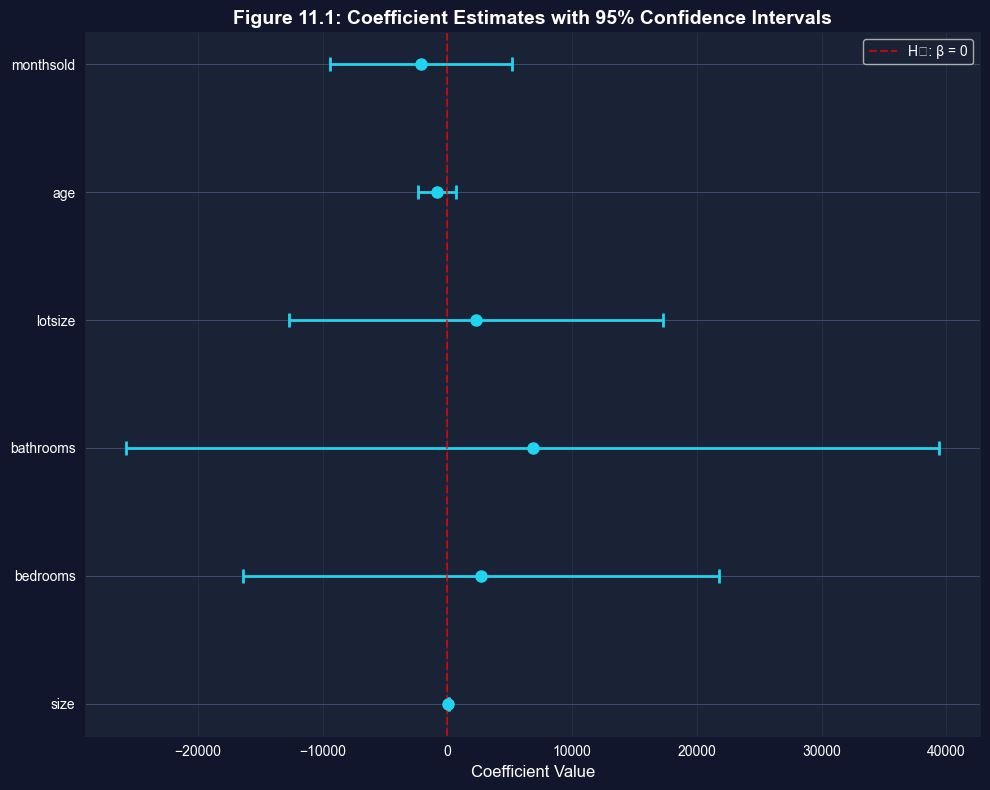

Coefficients whose CI crosses zero are not statistically significant at 5%.


In [21]:
# Figure 11.1: Confidence intervals for all coefficients
fig, ax = plt.subplots(figsize=(10, 8))

params_no_int = model_full.params[1:]
ci_no_int = conf_int.iloc[1:, :]

y_pos = np.arange(len(params_no_int))
ax.errorbar(params_no_int.values, y_pos,
            xerr=[params_no_int.values - ci_no_int.iloc[:, 0].values,
                  ci_no_int.iloc[:, 1].values - params_no_int.values],
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2, color='#22d3ee')
ax.set_yticks(y_pos)
ax.set_yticklabels(params_no_int.index)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
           label='H₀: β = 0')
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Figure 11.1: Coefficient Estimates with 95% Confidence Intervals',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Coefficients whose CI crosses zero are not statistically significant at 5%.")

### Visualization: F-Distribution

Visualize the F-distribution and show where our test statistic falls.

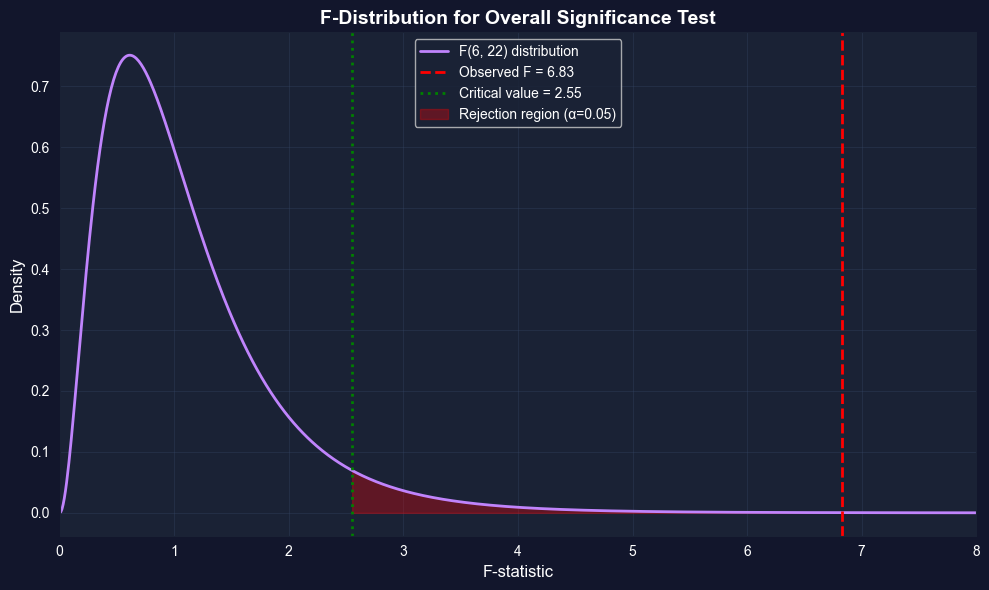

The observed F-statistic (6.83) exceeds the critical value (2.55).
This leads us to reject the null hypothesis of no relationship.


In [22]:
# Figure: F-distribution visualization
fig, ax = plt.subplots(figsize=(10, 6))

x_range = np.linspace(0, 10, 1000)
f_pdf = stats.f.pdf(x_range, dfn, dfd)

ax.plot(x_range, f_pdf, '-', color='#c084fc', linewidth=2, label=f'F({dfn}, {dfd}) distribution')
ax.axvline(x=f_stat, color='red', linewidth=2, linestyle='--',
           label=f'Observed F = {f_stat:.2f}')
ax.axvline(x=f_crit, color='green', linewidth=2, linestyle=':',
           label=f'Critical value = {f_crit:.2f}')

# Shade rejection region
x_reject = x_range[x_range >= f_crit]
f_reject = stats.f.pdf(x_reject, dfn, dfd)
ax.fill_between(x_reject, 0, f_reject, alpha=0.3, color='red',
                label='Rejection region (α=0.05)')

ax.set_xlabel('F-statistic', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('F-Distribution for Overall Significance Test',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max(8, f_stat + 1))
plt.tight_layout()
plt.show()

print(f"The observed F-statistic ({f_stat:.2f}) exceeds the critical value ({f_crit:.2f}).")
print("This leads us to reject the null hypothesis of no relationship.")

### Visualization: Model Comparison (Actual vs Predicted)

Compare the three models visually by plotting actual vs. predicted values.

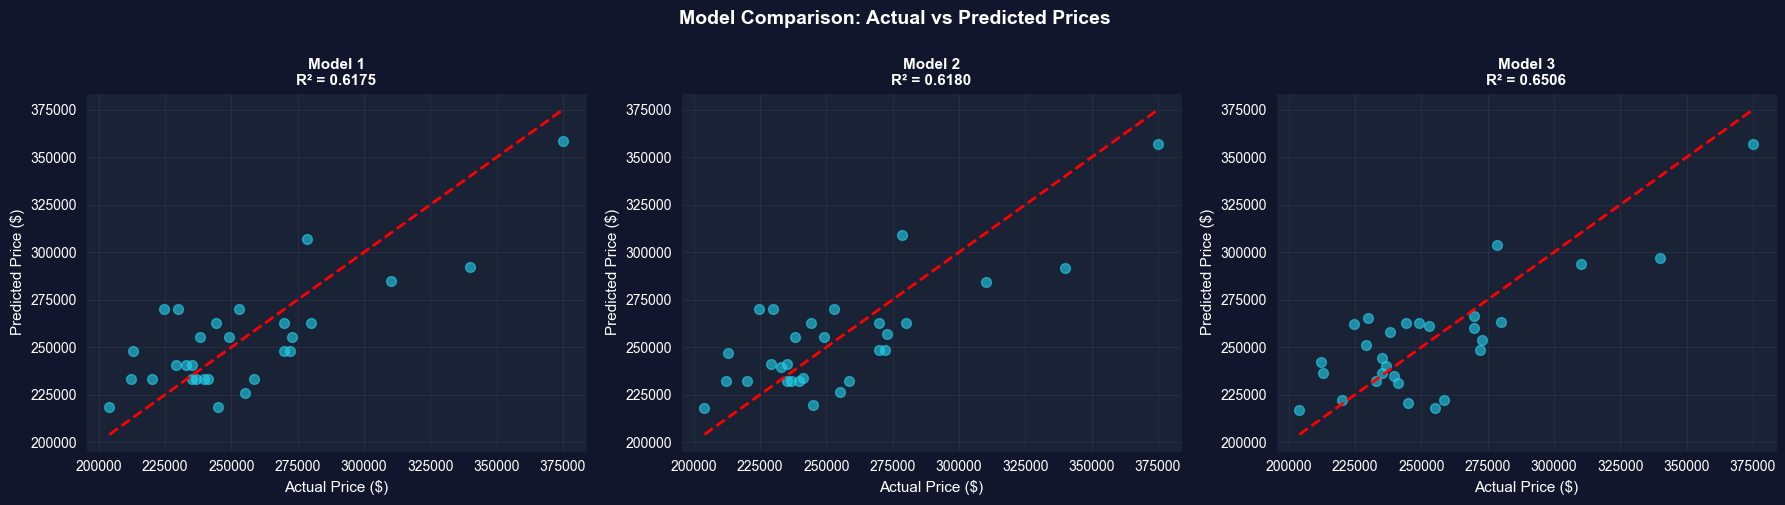

All three models show similar predictive performance.
The simplest model (Model 1) may be preferred for parsimony.


In [23]:
# Figure: Model comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model, name) in enumerate(zip(models, model_names)):
    axes[i].scatter(data_house['price'], model.fittedvalues,
                   alpha=0.6, s=50, color='#22d3ee')
    axes[i].plot([data_house['price'].min(), data_house['price'].max()],
                [data_house['price'].min(), data_house['price'].max()],
                'r--', linewidth=2)
    axes[i].set_xlabel('Actual Price ($)', fontsize=11)
    axes[i].set_ylabel('Predicted Price ($)', fontsize=11)
    axes[i].set_title(f'{name}\nR² = {model.rsquared:.4f}',
                     fontsize=11, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Model Comparison: Actual vs Predicted Prices',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("All three models show similar predictive performance.")
print("The simplest model (Model 1) may be preferred for parsimony.")

## Key Takeaways

**Classical Assumptions and OLS Properties:**

- Under assumptions 1-4 (linearity, random sampling, no perfect collinearity, zero conditional mean), OLS is unbiased, consistent, and efficient (BLUE)
- The standard error $se(b_j) = s_e / \sqrt{\sum \widetilde{x}_{ji}^2}$ decreases with larger samples, more variation in $x_j$, and lower multicollinearity
- The $t$-statistic $t = b_j / se(b_j)$ follows a $T(n-k)$ distribution

**Confidence Intervals:**

- 95% CI: $b_j \pm t_{n-k, 0.025} \times se(b_j)$
- If the CI excludes zero, the coefficient is statistically significant at 5%
- Narrower CIs indicate more precise estimation

**Individual Hypothesis Tests:**

- Test $H_0: \beta_j = \beta_j^*$ using $t = (b_j - \beta_j^*) / se(b_j)$
- Most common: test of significance $H_0: \beta_j = 0$ — does variable $x_j$ matter after controlling for others?
- Reject $H_0$ if $|t| > t_{\text{critical}}$ or equivalently if $p$-value $< \alpha$

**Joint F-Tests:**

- F-test evaluates multiple restrictions simultaneously: $F = \frac{(RSS_r - RSS_u)/q}{RSS_u/(n-k)} \sim F(q, n-k)$
- Overall significance test: $H_0: \beta_2 = \cdots = \beta_k = 0$ (all slopes zero)
- Subset tests: compare restricted vs. unrestricted models to decide if additional regressors are needed
- Equivalently: $F = \frac{(R_u^2 - R_r^2)/q}{(1 - R_u^2)/(n-k)}$

**Model Comparison and Selection:**

- Use F-tests to formally compare nested models
- Consider adjusted $R^2$, AIC, BIC alongside F-tests
- Prefer parsimony: if additional variables don't significantly improve fit, use the simpler model
- In our house price example, size alone was sufficient — five additional variables failed the joint F-test ($p = 0.83$)

**Presenting Results and Robust Inference:**

- Five standard formats: coefficients with (SEs), (t-stats), (p-values), (CIs), or (asterisks)
- Heteroskedasticity-robust (HC1) standard errors provide valid inference without assuming constant variance
- Report robust SEs by default for cross-sectional data

**Python tools used:** `statsmodels` (OLS, t_test, f_test, anova_lm, HC1), `scipy.stats` (t and F distributions), `matplotlib`/`seaborn` (coefficient plots, F-distribution)

**Next steps:** Chapter 12 covers **further inference and model specification** — additional diagnostic tests and extensions to the multiple regression framework.

Congratulations on completing Chapter 11! You can now conduct rigorous statistical inference for multiple regression models.

## Practice Exercises

Test your understanding of statistical inference for multiple regression.

---

**Exercise 1: Confidence Interval Calculation**

A multiple regression with $n = 200$ observations and $k = 4$ parameters yields:

- $b_2 = 5.0$, $se(b_2) = 2.0$
- $b_3 = 7.0$, $se(b_3) = 2.0$

a) Compute an approximate 95% confidence interval for $\beta_2$.

b) Compute an approximate 95% confidence interval for $\beta_3$.

c) Which coefficient is estimated more precisely? Explain.

---

**Exercise 2: Test of Statistical Significance**

Using the regression from Exercise 1:

a) Is $x_2$ statistically significant at the 5% level? Compute the $t$-statistic and state your conclusion.

b) Is $x_3$ statistically significant at the 5% level?

c) What is the approximate $p$-value for each coefficient?

---

**Exercise 3: Testing a Specific Value**

Using the same regression, test the claim that $\beta_3 = 10.0$ at significance level 0.05.

a) State the null and alternative hypotheses.

b) Compute the $t$-statistic.

c) What is your decision? Can you reject $H_0$?

---

**Exercise 4: Joint F-Test Setup**

Consider the model $y = \beta_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + u$.

We wish to test whether only $x_2$ and $x_3$ should be included in the model.

a) State $H_0$ and $H_a$ for this test.

b) How many restrictions are being tested ($q$)?

c) What are the degrees of freedom for the F-test if $n = 100$?

---

**Exercise 5: F-Statistic Computation**

You estimate two models on $n = 53$ observations:

- Restricted model ($k_r = 3$): $RSS_r = 40$
- Unrestricted model ($k_u = 6$): $RSS_u = 30$

a) Compute the F-statistic.

b) What are the degrees of freedom?

c) At $\alpha = 0.05$, would you reject the restrictions?

---

**Exercise 6: Regression Presentation**

Given these regression results:

| Variable | Coefficient | Std. Error | p-value |
|----------|------------|------------|--------|
| Intercept | 3.0 | 1.5 | 0.047 |
| $x_2$ | 5.0 | 2.0 | 0.013 |
| $x_3$ | 7.0 | 2.0 | 0.001 |

a) Present these results using the asterisk notation (`***` for $p < 0.01$, `**` for $p < 0.05$, `*` for $p < 0.10$).

b) Present using the coefficient (standard error) format.

c) Which variables are significant at the 1% level? At the 5% level?

## Case Studies

### Case Study 1: Statistical Inference for Cross-Country Productivity

In this case study, you will apply confidence intervals, hypothesis tests, and F-tests to investigate whether physical capital and human capital are statistically significant determinants of cross-country labor productivity differences.

**Dataset:** Mendez Convergence Clubs Data

- **Source:** Mendez (2020), 108 countries, 1990-2014
- **Key variables:**
  - `lp` — Labor productivity (GDP per worker)
  - `rk` — Physical capital per worker
  - `hc` — Human capital index
  - `region` — Geographic region

**Research question:** Are physical capital and human capital jointly significant in explaining cross-country labor productivity?

```python
# Load the Mendez convergence clubs dataset
url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat_2014 = dat[dat['year'] == 2014].dropna(subset=['lp', 'rk', 'hc']).copy()
dat_2014['ln_lp'] = np.log(dat_2014['lp'])
dat_2014['ln_rk'] = np.log(dat_2014['rk'])
print(f"Cross-section sample: {len(dat_2014)} countries (year 2014)")
dat_2014.head()
```

#### Task 1: Estimate Productivity Model (Guided)

Estimate the multiple regression model for labor productivity.

```python
# Estimate: ln(lp) = beta_0 + beta_1 * ln(rk) + beta_2 * hc + u
model_prod = ols('ln_lp ~ ln_rk + hc', data=dat_2014).fit()
print(model_prod.summary())
```

**Questions:**

- How many observations and parameters does the model have?
- What is the $R^2$? How much of productivity variation do capital and human capital explain?

#### Task 2: Confidence Intervals (Guided)

Compute and interpret 95% confidence intervals for the coefficients.

```python
# 95% confidence intervals
print("95% Confidence Intervals:")
print(model_prod.conf_int(alpha=0.05))

# Manual calculation for ln_rk coefficient
b_rk = model_prod.params['ln_rk']
se_rk = model_prod.bse['ln_rk']
df = model_prod.df_resid
t_crit = stats.t.ppf(0.975, df)
print(f"\nManual CI for ln(rk): [{b_rk - t_crit*se_rk:.4f}, {b_rk + t_crit*se_rk:.4f}]")
```

**Questions:**

- Does the CI for $\ln(\text{rk})$ exclude zero? What does this tell you?
- Does the CI for hc exclude zero? Interpret in economic terms.

> **Key Concept 11.9: Statistical Significance in Cross-Country Regressions**
>
> With over 100 countries, cross-country regressions have sufficient power to detect moderate effects. However, statistical significance does not imply causation — unobserved factors (institutions, geography, culture) may confound the relationship between capital inputs and productivity. Confidence intervals quantify estimation uncertainty but not omitted variable bias.

#### Task 3: Individual Hypothesis Tests (Semi-guided)

Test the statistical significance of each coefficient.

```python
# Test significance of each coefficient
print("t-statistics and p-values:")
for var in ['ln_rk', 'hc']:
    t = model_prod.tvalues[var]
    p = model_prod.pvalues[var]
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
    print(f"  {var}: t = {t:.3f}, p = {p:.4f} {sig}")
```

**Questions:**

- Which coefficients are significant at the 1% level? At the 5% level?
- Interpret the economic meaning: what does significance of $\ln(\text{rk})$ tell us about physical capital?

#### Task 4: Joint F-Test (Semi-guided)

Test whether physical capital and human capital are jointly significant.

```python
# Overall F-test: H0: beta_1 = beta_2 = 0
print(f"Overall F-statistic: {model_prod.fvalue:.4f}")
print(f"p-value: {model_prod.f_pvalue:.6e}")

# Compare to restricted model (intercept only)
model_restricted = ols('ln_lp ~ 1', data=dat_2014).fit()
anova_result = anova_lm(model_restricted, model_prod)
print("\nANOVA comparison:")
print(anova_result)
```

**Questions:**

- Can you reject $H_0: \beta_1 = \beta_2 = 0$? What does this mean economically?
- How does the F-test relate to the individual $t$-tests?

#### Task 5: Model Comparison (Independent)

Compare nested models to determine the best specification.

**Your tasks:**

1. Estimate three models: (a) $\ln(\text{lp}) \sim \ln(\text{rk})$ only, (b) $\ln(\text{lp}) \sim \text{hc}$ only, (c) both regressors
2. Create a model comparison table with $R^2$, adjusted $R^2$, AIC, BIC
3. Conduct subset F-tests: does adding hc to the $\ln(\text{rk})$-only model significantly improve fit?
4. Report robust standard errors for the preferred model

*Hint: Use `anova_lm(model_restricted, model_unrestricted)` for the F-test and `model.get_robustcov_results(cov_type='HC1')` for robust SEs.*

#### Task 6: Inference Policy Brief (Independent)

Write a 200-300 word policy brief summarizing your inference results.

**Your brief should address:**

1. Which factors are statistically significant predictors of cross-country productivity?
2. What are the 95% confidence intervals for the effects of capital and human capital?
3. Are both factors jointly significant? What does the F-test tell us?
4. What policy implications follow from these findings?
5. What caveats should policymakers consider (association vs. causation, omitted variables)?

> **Key Concept 11.10: From Statistical Significance to Policy Relevance**
>
> Finding that both physical and human capital are statistically significant predictors of productivity suggests that investments in both areas may boost economic output. However, the magnitudes matter for policy: confidence intervals tell us the plausible range of effects, while F-tests confirm that both factors jointly matter beyond what each contributes alone. Policy decisions should weigh statistical evidence alongside practical considerations like cost-effectiveness and implementation feasibility.

### What You've Learned

In this case study, you applied the full statistical inference toolkit to cross-country productivity data:

- Estimated multiple regression models and examined coefficient properties
- Constructed and interpreted confidence intervals for partial effects
- Conducted individual $t$-tests to assess each predictor's significance
- Performed joint F-tests to evaluate whether both capital types matter
- Compared nested models and reported results with robust standard errors

These inferential tools are essential for drawing reliable conclusions from empirical economic analysis.

### Case Study 2: Which Satellite Features Matter? Joint Tests for Predictive Power

In Chapter 10, we estimated a multiple regression of municipal development on nighttime lights and satellite embeddings. Now we apply Chapter 11's inference tools—t-tests for individual coefficients and F-tests for joint significance—to determine which satellite features add statistically significant predictive power.

**Dataset:** DS4Bolivia — Satellite Data for Sustainable Development

- **Source:** [DS4Bolivia Project](https://github.com/quarcs-lab/ds4bolivia), 339 municipalities
- **Key variables:**
  - `imds` — Municipal Sustainable Development Index (0-100 composite)
  - `ln_NTLpc2017` — Log nighttime lights per capita (2017)
  - `A00`, `A10`, `A20`, `A30`, `A40` — Selected satellite image embedding dimensions

**Research question:** Do satellite image embeddings add statistically significant predictive power for municipal development beyond nighttime lights alone?

```python
# Load the DS4Bolivia dataset
url_bol = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/ds4bolivia_v20250523.csv"
bol = pd.read_csv(url_bol)

# Select variables and prepare analysis sample
embed_vars = ['A00', 'A10', 'A20', 'A30', 'A40']
analysis_vars = ['imds', 'ln_NTLpc2017'] + embed_vars
bol_cs = bol[['mun', 'dep'] + analysis_vars].dropna(subset=analysis_vars).copy()
print(f"Analysis sample: {len(bol_cs)} municipalities with complete data")
bol_cs[analysis_vars].describe().round(3)
```

#### Task 1: Estimate Full Model (Guided)

Estimate the full multiple regression model with nighttime lights and all five satellite embedding dimensions as predictors of municipal development.

```python
# Estimate: imds = beta_0 + beta_1*ln_NTLpc2017 + beta_2*A00 + ... + beta_6*A40 + u
model_full = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40', data=bol_cs).fit()
print(model_full.summary())
```

**Questions:**

- How many coefficients are estimated (including the intercept)?
- Which coefficients have p-values below 0.05? Below 0.10?
- What is the overall $R^2$? How much variation in development does this model explain?
- Compare this $R^2$ to a model with NTL alone—how much do the embeddings add?

In [24]:
# Your code here: Estimate the full model
#
# Steps:
# 1. Estimate the full model with NTL and all 5 embeddings
# 2. Print the full summary
# 3. Identify significant coefficients (p < 0.05 and p < 0.10)

# Example structure:
# model_full = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40', data=bol_cs).fit()
# print(model_full.summary())
#
# # Identify significant predictors
# print("\nSignificance at 5% level:")
# for var in model_full.params.index:
#     p = model_full.pvalues[var]
#     sig = "***" if p < 0.01 else "**" if p < 0.05 else "*" if p < 0.10 else ""
#     print(f"  {var:18s}  p = {p:.4f}  {sig}")

#### Task 2: Confidence Intervals (Guided)

Compute 95% confidence intervals for all coefficients and create a coefficient plot (forest plot) to visualize the estimates and their uncertainty.

```python
# 95% confidence intervals
ci = model_full.conf_int(alpha=0.05)
ci.columns = ['Lower 2.5%', 'Upper 97.5%']
ci['Estimate'] = model_full.params
print(ci[['Estimate', 'Lower 2.5%', 'Upper 97.5%']].round(4))
```

**Questions:**

- Which confidence intervals include zero? What does this imply about significance?
- Which coefficient has the widest confidence interval? The narrowest (excluding intercept)?
- Create a forest plot showing point estimates and 95% CIs for the embedding coefficients
- How do the confidence intervals for embeddings compare in width to the NTL coefficient?

In [25]:
# Your code here: Confidence intervals and coefficient plot
#
# Steps:
# 1. Compute confidence intervals with model_full.conf_int()
# 2. Print the table of estimates and CIs
# 3. Create a coefficient plot (forest plot) for embedding variables
# 4. Identify which CIs include zero

# Example structure:
# ci = model_full.conf_int(alpha=0.05)
# ci.columns = ['Lower', 'Upper']
# ci['Estimate'] = model_full.params
# print(ci[['Estimate', 'Lower', 'Upper']].round(4))
#
# # Forest plot for embedding coefficients
# embed_vars = ['A00', 'A10', 'A20', 'A30', 'A40']
# fig, ax = plt.subplots(figsize=(8, 5))
# y_pos = range(len(embed_vars))
# estimates = [model_full.params[v] for v in embed_vars]
# errors = [(model_full.params[v] - ci.loc[v, 'Lower'],
#            ci.loc[v, 'Upper'] - model_full.params[v]) for v in embed_vars]
# errors_T = list(zip(*errors))
# ax.errorbar(estimates, y_pos, xerr=errors_T, fmt='o', color='navy',
#             capsize=5, markersize=8)
# ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero (no effect)')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(embed_vars)
# ax.set_xlabel('Coefficient Estimate with 95% CI')
# ax.set_title('Coefficient Plot: Satellite Embedding Effects on IMDS')
# ax.legend()
# plt.tight_layout()
# plt.show()

#### Task 3: Individual t-Tests (Semi-guided)

Examine the t-statistics and p-values for each satellite embedding coefficient individually.

**Your tasks:**

1. Extract and display the t-statistic and p-value for each embedding variable (`A00`-`A40`)
2. Classify each as significant at 5%, significant at 10%, or not significant
3. Count how many of the 5 embeddings are individually significant at each level
4. Discuss: If some embeddings are individually insignificant, can we conclude they are "useless"? Why or why not?

**Hint:** Individual insignificance may reflect multicollinearity among embeddings rather than lack of predictive power. The joint F-test in Task 4 will help resolve this.

In [26]:
# Your code here: Individual t-tests for embedding coefficients
#
# Steps:
# 1. Extract t-statistics and p-values for each embedding
# 2. Classify significance levels
# 3. Discuss the implications

# Example structure:
# print("Individual t-Tests for Satellite Embeddings")
# print("=" * 60)
# embed_vars = ['A00', 'A10', 'A20', 'A30', 'A40']
# sig_5 = 0
# sig_10 = 0
# for var in embed_vars:
#     t = model_full.tvalues[var]
#     p = model_full.pvalues[var]
#     if p < 0.05:
#         level = "Significant at 5%  ***"
#         sig_5 += 1
#         sig_10 += 1
#     elif p < 0.10:
#         level = "Significant at 10% *"
#         sig_10 += 1
#     else:
#         level = "Not significant"
#     print(f"  {var}: t = {t:7.3f}, p = {p:.4f}  --> {level}")
# print(f"\nSignificant at 5%:  {sig_5}/5 embeddings")
# print(f"Significant at 10%: {sig_10}/5 embeddings")

#### Task 4: Joint F-Test (Semi-guided)

Test whether all five satellite embedding coefficients are jointly equal to zero.

$$H_0: \beta_{A00} = \beta_{A10} = \beta_{A20} = \beta_{A30} = \beta_{A40} = 0$$

**Your tasks:**

1. Construct a restriction matrix $R$ where each row sets one embedding coefficient to zero
2. Use `model_full.f_test()` with the restriction matrix to compute the joint F-statistic
3. Report the F-statistic, degrees of freedom, and p-value
4. Compare the joint test result with the individual t-test results from Task 3
5. Are embeddings *jointly* significant even if some are individually insignificant?

**Hint:** The restriction matrix has 5 rows (one per restriction) and 7 columns (one per coefficient including intercept). Each row has a 1 in the position of the embedding coefficient being tested and 0s elsewhere.

In [27]:
# Your code here: Joint F-test for all embedding coefficients
#
# Steps:
# 1. Construct the restriction matrix R
# 2. Perform the joint F-test with model_full.f_test(R)
# 3. Report F-statistic and p-value
# 4. Compare with individual t-test results

# Example structure:
# import numpy as np
#
# # Restriction matrix: 5 restrictions (A00=A10=A20=A30=A40=0)
# # Coefficients order: Intercept, ln_NTLpc2017, A00, A10, A20, A30, A40
# R = np.zeros((5, 7))
# R[0, 2] = 1  # A00 = 0
# R[1, 3] = 1  # A10 = 0
# R[2, 4] = 1  # A20 = 0
# R[3, 5] = 1  # A30 = 0
# R[4, 6] = 1  # A40 = 0
#
# f_test = model_full.f_test(R)
# print("Joint F-Test: All Embedding Coefficients = 0")
# print("=" * 50)
# print(f"F-statistic: {f_test.fvalue[0][0]:.4f}")
# print(f"p-value:     {f_test.pvalue:.6f}")
# print(f"df:          ({int(f_test.df_num)}, {int(f_test.df_denom)})")
# print(f"\nConclusion: {'Reject H0' if f_test.pvalue < 0.05 else 'Fail to reject H0'} at 5% level")

> **Key Concept 11.12: Joint Significance of Satellite Features**
>
> Individual satellite embedding coefficients may appear **statistically insignificant** (p > 0.05) in a multiple regression, yet the group of embeddings may be **jointly significant** (F-test p < 0.05). This paradox arises when embeddings are correlated with each other: the individual t-tests cannot distinguish each embedding's unique contribution, but the F-test captures their collective explanatory power. Joint F-tests are essential when evaluating groups of related predictors.

#### Task 5: Restricted vs Unrestricted Model Comparison (Independent)

Compare the restricted model (NTL only) with the unrestricted model (NTL + embeddings) to quantify the contribution of satellite embeddings.

**Your tasks:**

1. Estimate Model 1 (restricted): `imds ~ ln_NTLpc2017` (NTL only)
2. Estimate Model 2 (unrestricted): `imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40`
3. Compute the F-statistic manually using the formula:

$$F = \frac{(R^2_u - R^2_r) / q}{(1 - R^2_u) / (n - k - 1)}$$

where $q = 5$ (number of restrictions), $n$ = sample size, $k$ = number of regressors in unrestricted model

4. Compare your manual calculation with `model_full.compare_f_test(model_restricted)`
5. Interpret: How much do the embeddings improve the model's explanatory power?

In [28]:
# Your code here: Restricted vs unrestricted model comparison
#
# Steps:
# 1. Estimate restricted model (NTL only)
# 2. Compare R-squared values
# 3. Compute F-statistic manually
# 4. Verify with compare_f_test()

# Example structure:
# # Restricted model: NTL only
# model_restricted = ols('imds ~ ln_NTLpc2017', data=bol_cs).fit()
#
# # Compare R-squared
# R2_r = model_restricted.rsquared
# R2_u = model_full.rsquared
# n = model_full.nobs
# k = len(model_full.params) - 1  # number of regressors (excluding intercept)
# q = 5  # number of restrictions (embedding coefficients)
#
# print("Model Comparison")
# print("=" * 50)
# print(f"Restricted (NTL only):      R² = {R2_r:.4f}")
# print(f"Unrestricted (NTL + embed): R² = {R2_u:.4f}")
# print(f"Improvement in R²:          ΔR² = {R2_u - R2_r:.4f}")
#
# # Manual F-statistic
# F_manual = ((R2_u - R2_r) / q) / ((1 - R2_u) / (n - k - 1))
# print(f"\nManual F-statistic: {F_manual:.4f}")
#
# # Verify with statsmodels
# f_compare = model_full.compare_f_test(model_restricted)
# print(f"compare_f_test:     F = {f_compare[0]:.4f}, p = {f_compare[1]:.6f}")

#### Task 6: Inference Brief (Independent)

Write a 200-300 word inference brief summarizing your statistical findings.

**Your brief should address:**

1. Which satellite features add significant predictive power for municipal development?
2. Does the joint F-test tell a different story than the individual t-tests? Why?
3. How much do satellite embeddings improve explanatory power beyond nighttime lights alone?
4. What are the implications for feature selection in satellite-based prediction models?
5. How should researchers decide which satellite features to include in SDG prediction models?

**Connection to methods:** This analysis demonstrates a core tension in applied econometrics: individual insignificance vs. joint significance. When predictors are correlated (as satellite embeddings often are), individual t-tests may lack power while joint F-tests reveal collective importance.

In [29]:
# Your code here: Additional analysis for the inference brief
#
# You might want to:
# 1. Create a summary table comparing individual and joint test results
# 2. Visualize the R-squared improvement from adding embeddings
# 3. Calculate specific statistics to cite in your brief

# Example: Summary of key inference results
# print("KEY INFERENCE RESULTS")
# print("=" * 60)
# print(f"Sample size: {int(model_full.nobs)} municipalities")
# print(f"R² (NTL only):          {model_restricted.rsquared:.4f}")
# print(f"R² (NTL + embeddings):  {model_full.rsquared:.4f}")
# print(f"R² improvement:         {model_full.rsquared - model_restricted.rsquared:.4f}")
# print(f"\nJoint F-test p-value:   {f_test.pvalue:.6f}")
# print(f"Individually significant at 5%: {sig_5}/5 embeddings")
# print(f"Individually significant at 10%: {sig_10}/5 embeddings")

> **Key Concept 11.13: Feature Selection in Prediction Models**
>
> When many potential predictors are available (e.g., 64 satellite embedding dimensions), selecting which to include requires balancing **explanatory power** against **model parsimony**. Joint F-tests help determine whether *subsets* of features add genuine predictive value beyond what simpler models provide. In the DS4Bolivia context, testing whether 5 selected embeddings improve upon NTL alone informs practical decisions about data collection and model complexity for SDG monitoring.

#### What You've Learned from This Case Study

Through this analysis of satellite features and municipal development in Bolivia, you applied Chapter 11's full inference toolkit to a remote sensing application:

- **Full model estimation**: Estimated a multiple regression with nighttime lights and satellite embeddings as predictors of development
- **Confidence intervals**: Constructed and visualized 95% CIs for all coefficients using a forest plot
- **Individual t-tests**: Assessed the statistical significance of each satellite embedding individually
- **Joint F-tests**: Tested whether all embeddings are jointly significant using restriction matrices
- **Restricted vs unrestricted comparison**: Computed F-statistics manually and verified with `compare_f_test()`
- **Inference interpretation**: Distinguished between individual insignificance and joint significance

**Connection to the next chapter**: In Chapter 12, we address robust standard errors and prediction intervals—crucial for making reliable predictions about individual municipalities.

---

**Well done!** You've now applied the full statistical inference toolkit to two datasets—cross-country productivity and Bolivian satellite data—discovering that joint tests can reveal predictive power hidden from individual tests.